# Get to Data

## Load Dataset

In [1]:
# Import Modules
# Data Analysis and Visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
df = pd.read_csv('daily_revenue.csv')
df.head()

,date,revenue,discount_rate,coupon_rate
0,1/1/2018,"6,270,839",34.27%,1.09%
1,2/1/2018,"8,922,076",30.87%,1.08%
2,3/1/2018,"8,446,101",28.11%,1.01%
3,4/1/2018,"7,785,798",27.32%,0.96%
4,5/1/2018,"6,375,303",25.70%,0.90%


## Data Preprocessings

In [3]:
# see the information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1795 non-null   object
 1   revenue        1795 non-null   object
 2   discount_rate  1795 non-null   object
 3   coupon_rate    1795 non-null   object
dtypes: object(4)
memory usage: 56.2+ KB


In [4]:
# convert date into datetime object
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# convert revenue, discount_rate, and coupon_rate into float
df['revenue'] = df['revenue'].str.replace(',','').astype('float')
df['discount_rate'] = df['discount_rate'].str.replace('%','').astype('float') / 100
df['coupon_rate'] = df['coupon_rate'].str.replace('%','').astype('float')

# set date into index
df.set_index('date', inplace=True)
df = df.asfreq('D')

# see the result
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,0.3427,1.09
2018-01-02,8922076.0,0.3087,1.08
2018-01-03,8446101.0,0.2811,1.01
2018-01-04,7785798.0,0.2732,0.96
2018-01-05,6375303.0,0.2570,0.90


In [5]:
# Check the index data frequencies
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

The data is weell set, and ready to go for further analysis

# Exploratory Data Analysis

## See The Data

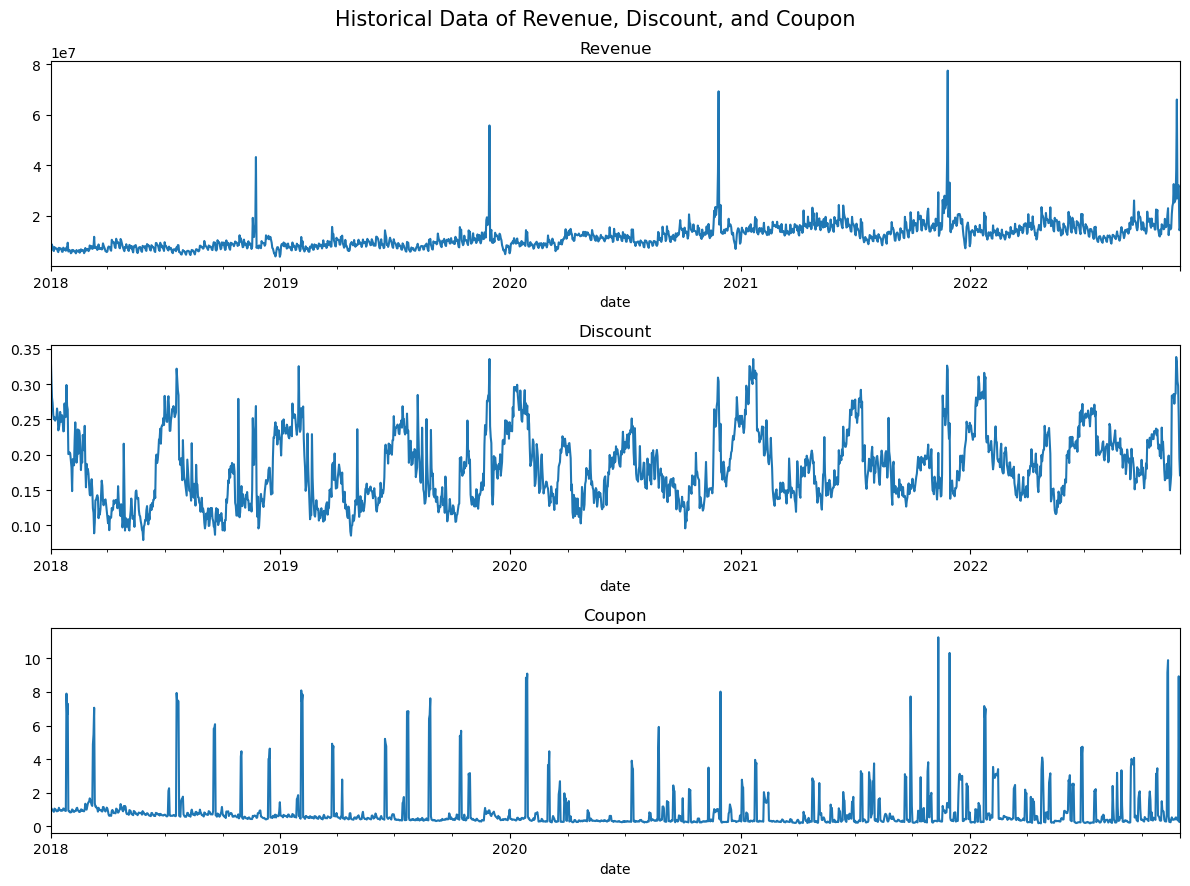

In [6]:
fig, ax = plt.subplots(3,1, figsize=(12, 9))
ax = ax.flatten()

df.revenue.plot(ax=ax[0], title='Revenue')
df.discount_rate.plot(ax=ax[1], title='Discount')
df.coupon_rate.plot(ax=ax[2], title='Coupon')

plt.suptitle('Historical Data of Revenue, Discount, and Coupon', size=15)
plt.tight_layout()
plt.show();

## Check Correlations

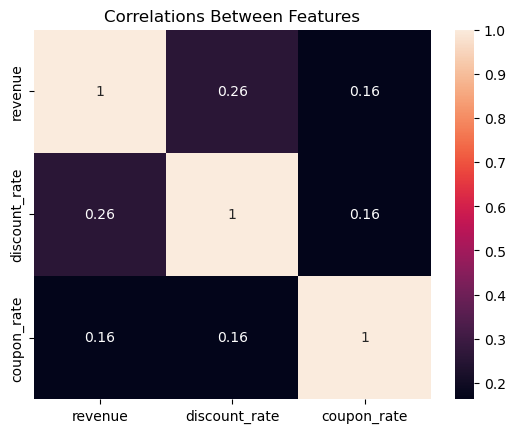

In [7]:
sns.heatmap(df.corr(), annot=True)
plt.title("Correlations Between Features")
plt.show();

The correlation of Exogenuos Variable towards revenue is considered as weak. Put exogenuous variable into model could potentially increase noises and create model the underperform, in addition with increasing computational resources needed. So it is best practice to first ignore the Exogenuos variable to dataset. But it is also worth to try to explore Exogenuous Variable a little bit in hope to find an insight.

## Dataset Decompositions

In [14]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL

In [9]:
def decompose(df, column_name='revenue', model = 'mul', period=365,
              figsize=(12, 4)):
    # Seasonal Decomposition Plots for complaint values
    # Multiplicative model type, with yearly seasonality (52 weeks)
    
    decomposition = seasonal_decompose(df[column_name],
                                       model = model,
                                       period = period)
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    
    if (model == 'mul') or (model == 'muliplicative'):
        model = 'Multiplicative'
    else: 'Additive'
    
    fig.suptitle(f"Decomposition of {column_name.title()} using {model.title()} Model Type",size=int(1.3*figsize[0]))
    plt.show()

In [10]:
def check_seasonality(df, col = 'revenue', m = 183, return_result = False, print_result=True):
    """
    Function to check for seasonality at lag m using Ljung-Box test.
    """
    # Perform the Ljung-Box test at lag m
    lb_test = acorr_ljungbox(df[col], lags=[m], return_df=True)
    
    if print_result:
        print("Ljung-Box Test at lag:", m)
        print(lb_test)
        if lb_test['lb_pvalue'].values[0] < 0.05:
            print(f"Significant seasonality detected at lag {m} (p-value: {lb_test['lb_pvalue'].values[0]:.4f})")
        else:
            print(f"No significant seasonality detected at lag {m} (p-value: {lb_test['lb_pvalue'].values[0]:.4f})")

    if return_result:
        return lb_test

def inspect_seasonality(df, col = 'revenue', m_list = [7, 30, 90, 183, 365]):
    # create result dataframe
    res = pd.DataFrame()
    
    # inspect for all period list
    for m in m_list:
        row = check_seasonality(df, col, m=m, return_result = True, print_result=False)
        res = pd.concat([res, row])
        
    # present result
    res = res.reset_index()
    res.rename(columns={
        'index' : 'period'
    }, inplace=True)
    res['rank'] = res['lb_stat'].rank(ascending=False)
    res.sort_values(by='rank', axis=0, ascending=True, inplace=True)
    
    return res

In [29]:
def plot_seasonal(df, column_name='revenue', period=7, figsize=(18, 12)):
    # Decompose using STL
    stl = STL(df[column_name], period=period)  # 7 for weekly seasonality (daily data)
    result = stl.fit()
    
    # Modify figsize using subplots
    fig, axes = plt.subplots(4, 1, figsize=figsize)  # 4 rows for trend, seasonal, resid, and observed components
    
    # Plot each component separately
    result.observed.plot(ax=axes[0], title='Observed', color='blue')
    result.trend.plot(ax=axes[1], title='Trend', color='green')
    result.seasonal.plot(ax=axes[2], title='Seasonal', color='red')
    result.resid.plot(ax=axes[3], title='Residual', color='purple')
    
    plt.tight_layout()
    plt.show()

### Revenue Decompositions

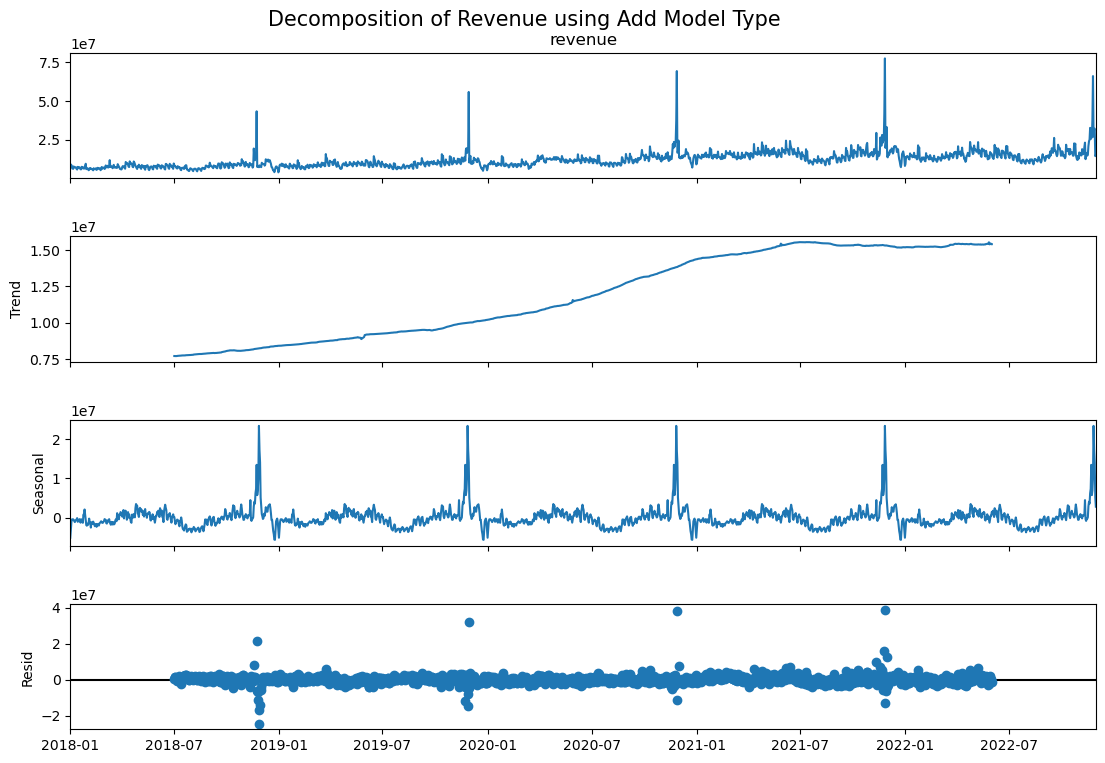

In [11]:
decompose(df, 'revenue', model='add')

In [13]:
inspect_seasonality(df, col = 'revenue')

,period,lb_stat,lb_pvalue,rank
4,365,72813.242117,0.0,1.0
3,183,46231.680657,0.0,2.0
2,90,26391.123757,0.0,3.0
1,30,13401.633083,0.0,4.0
0,7,4839.141572,0.0,5.0


The Revenue Data is actually a complex seasonality that exist in yearly, half-yearly, quarterly, monthly and weekly period. But the strongest seasonality exist in yearly period. But in the sake of simplicity, we will use weekly seasonality

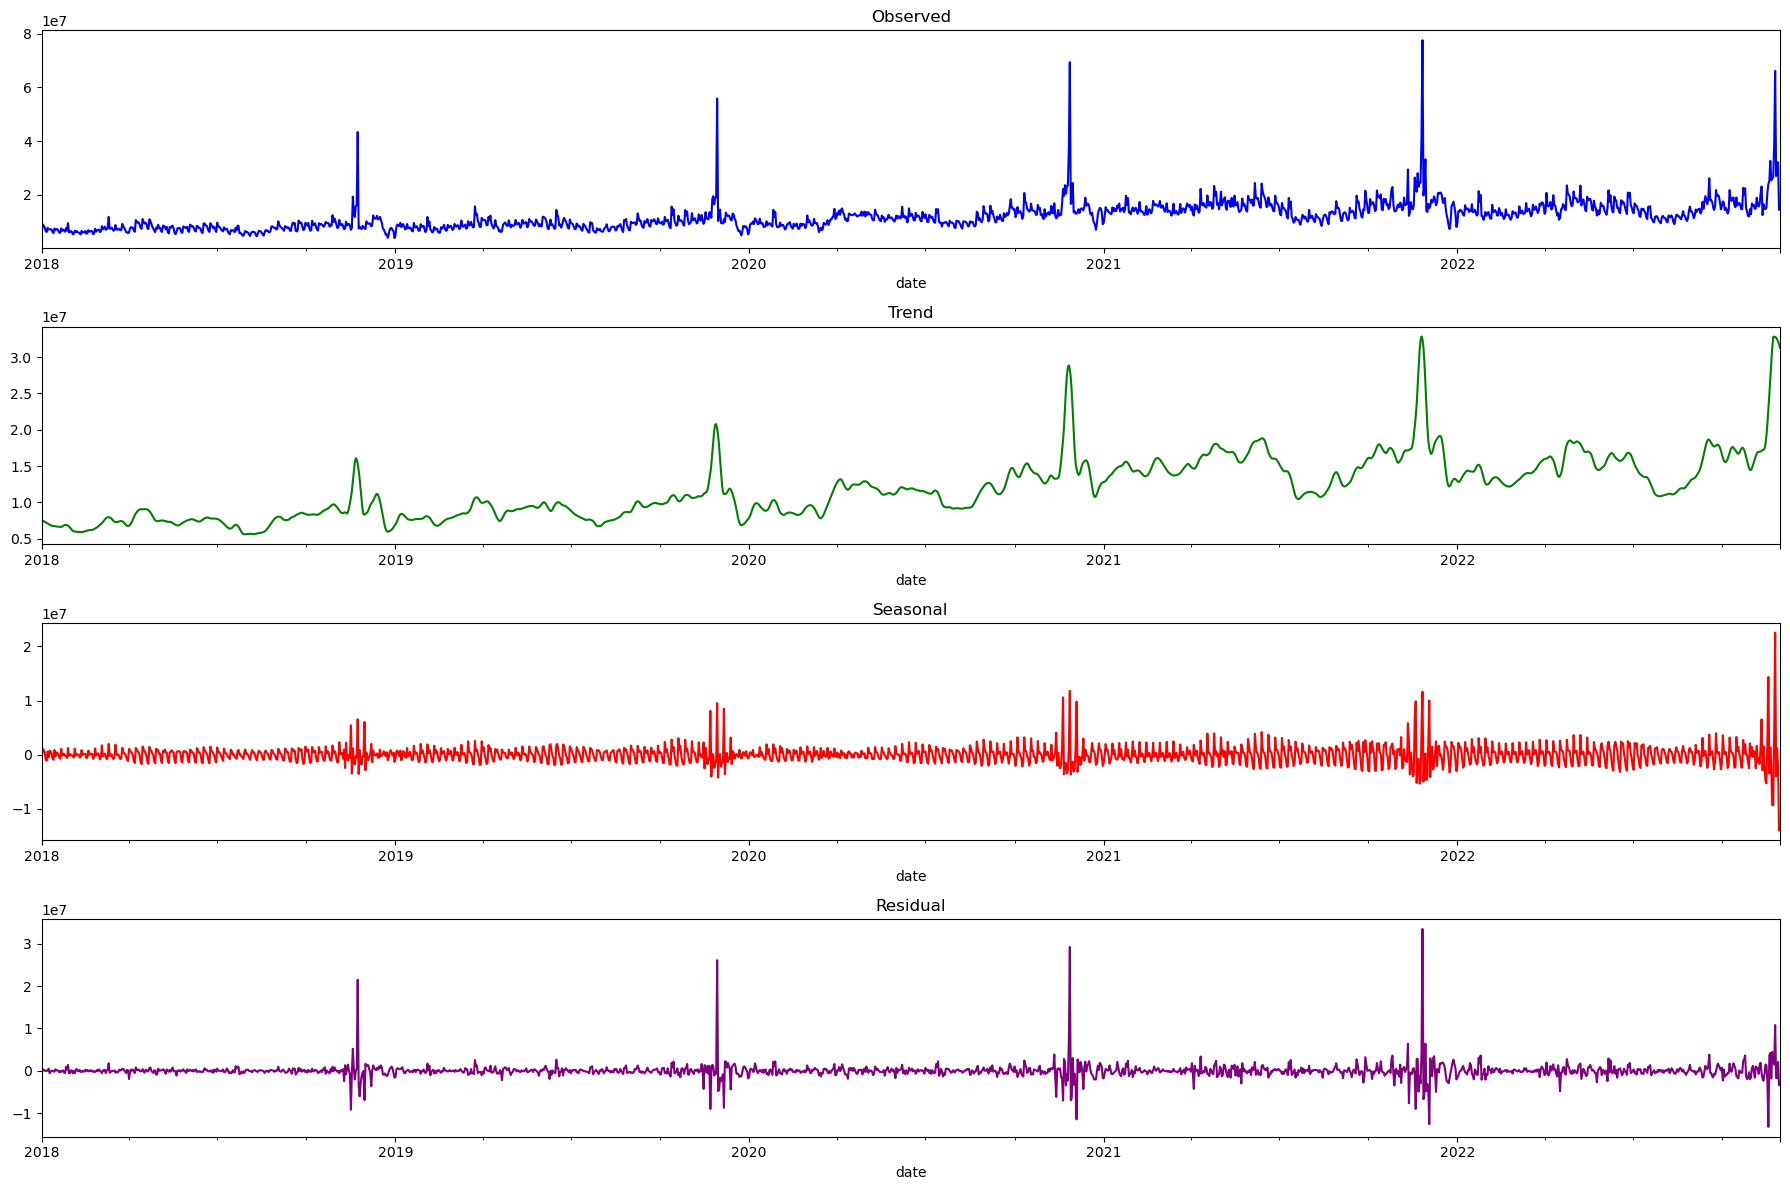

In [28]:
plot_seasonal(df, column_name='revenue', period=7, figsize=(18, 12))

### Discount Rate Decompositions

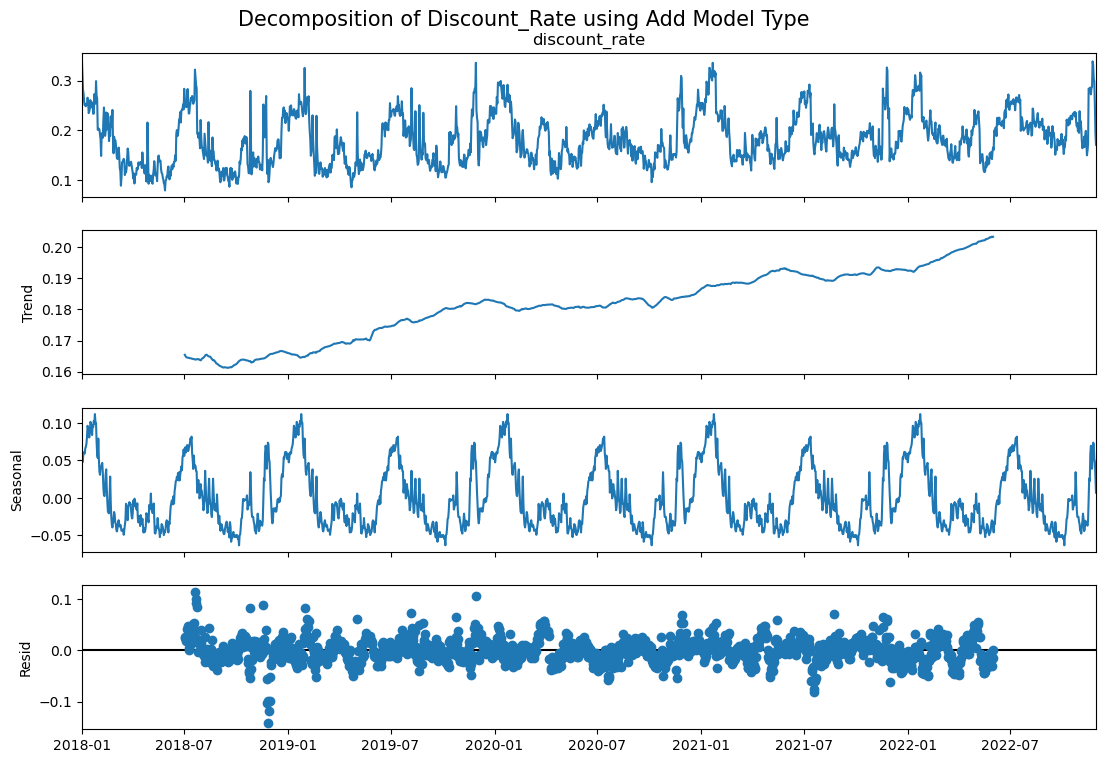

In [30]:
decompose(df, 'discount_rate', model='add')

In [32]:
inspect_seasonality(df, col = 'discount_rate')

,period,lb_stat,lb_pvalue,rank
4,365,50456.827234,0.0,1.0
3,183,29155.663961,0.0,2.0
2,90,17593.514894,0.0,3.0
1,30,14573.681920,0.0,4.0
0,7,7763.194091,0.0,5.0


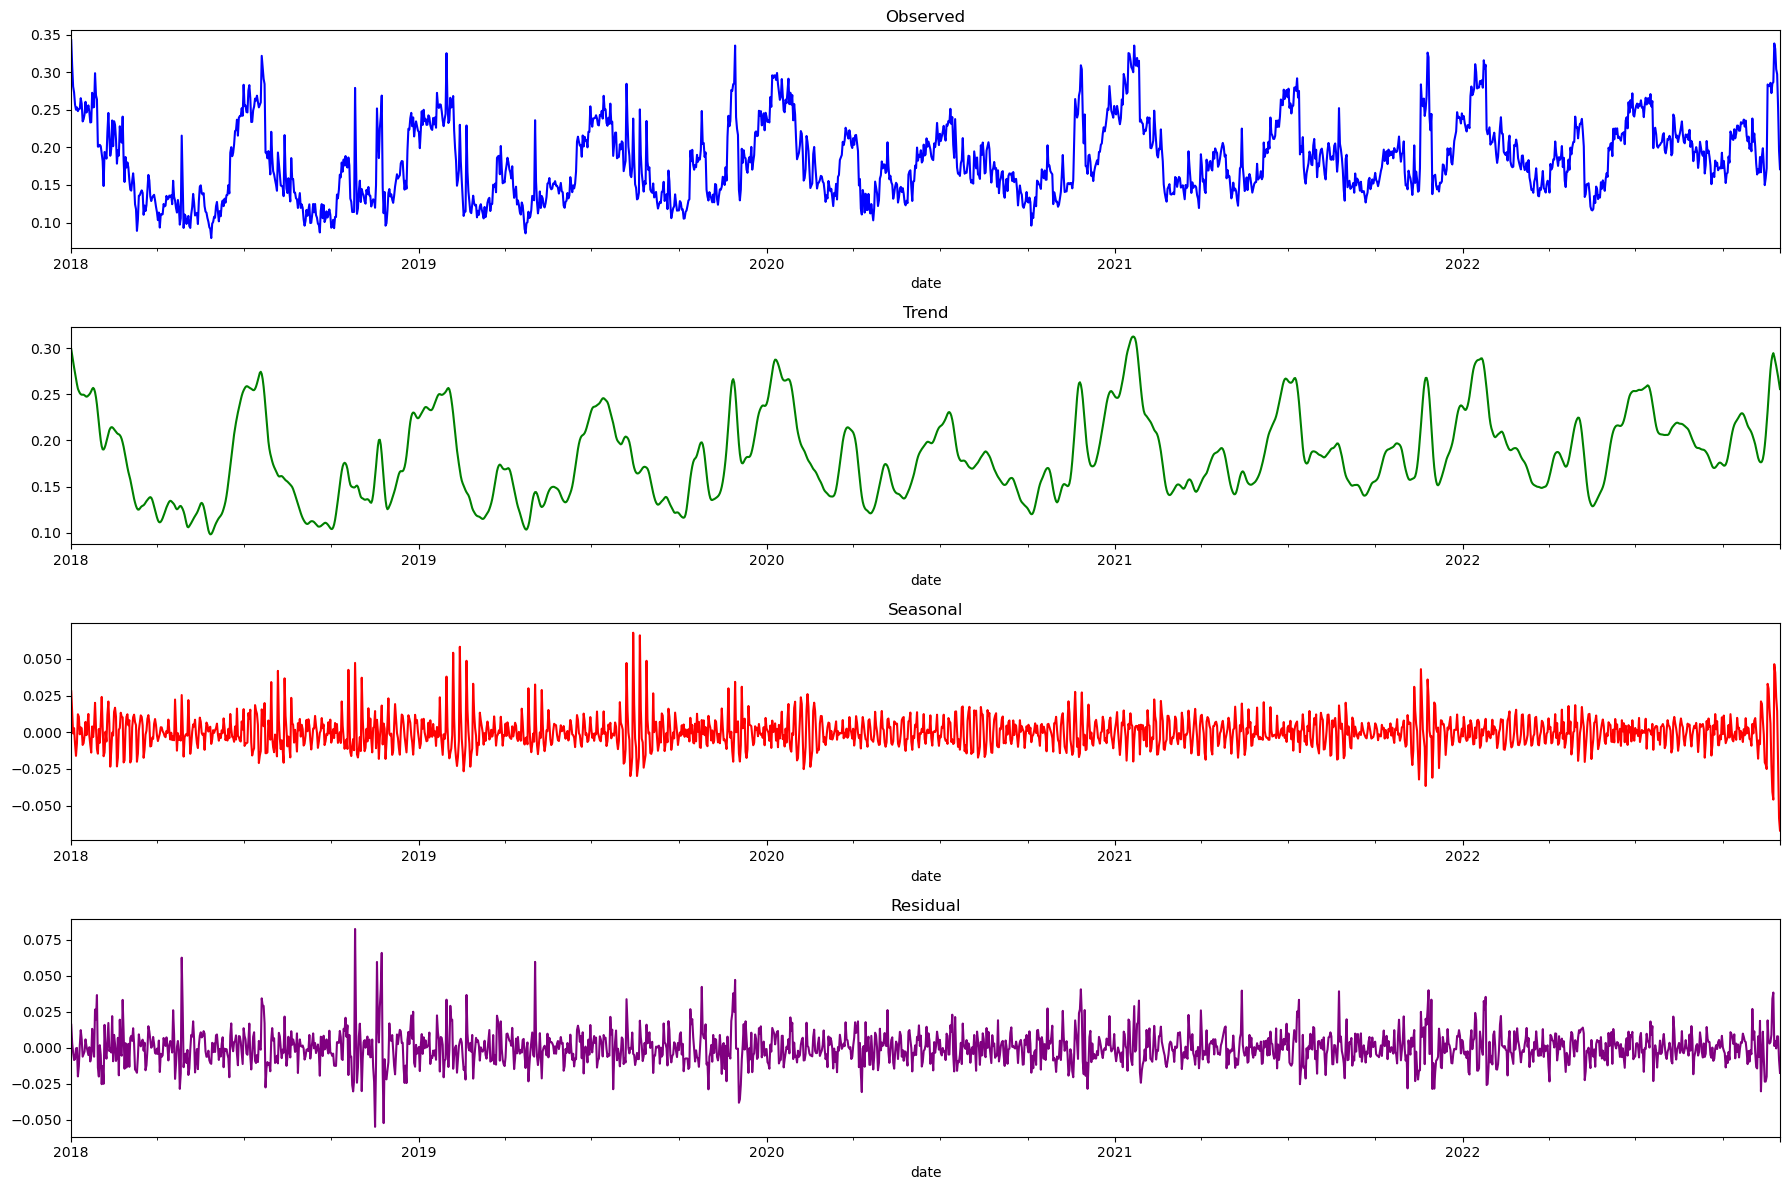

In [31]:
plot_seasonal(df, column_name='discount_rate', period=7, figsize=(18, 12))

### Coupon Rate Decompositions

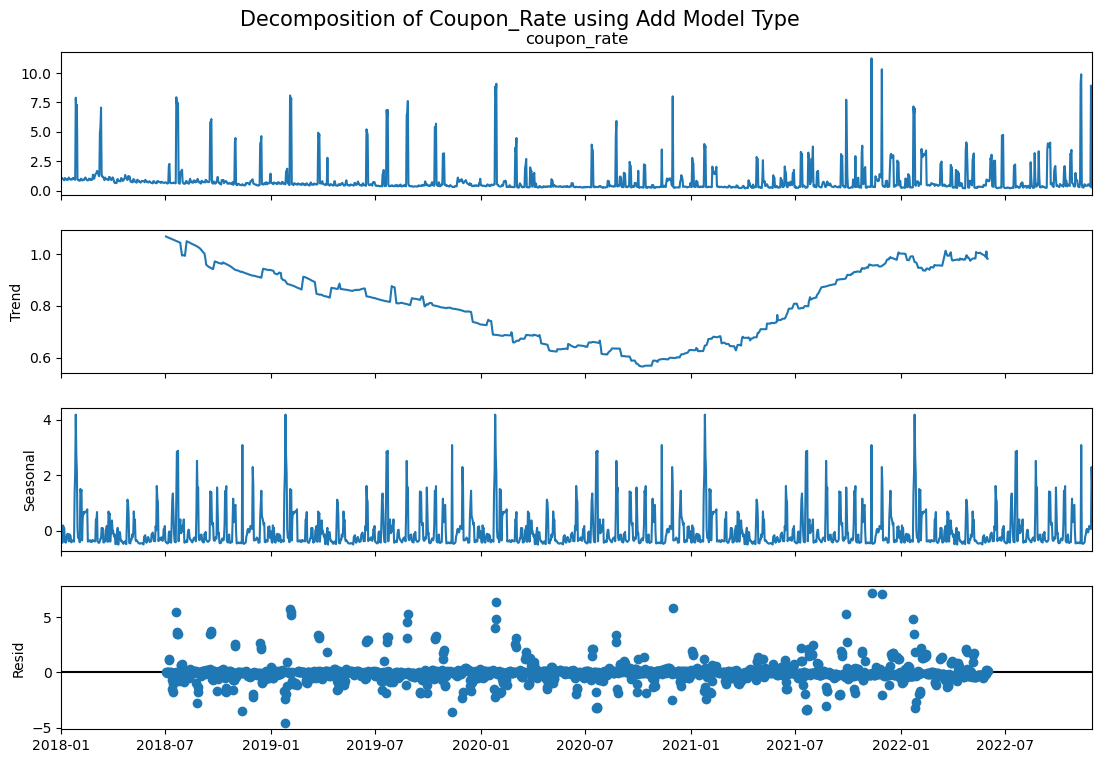

In [33]:
decompose(df, 'coupon_rate', model='add')

In [34]:
inspect_seasonality(df, col = 'coupon_rate')

,period,lb_stat,lb_pvalue,rank
4,365,1746.714359,8.764944e-179,1.0
3,183,1121.758934,1.291875e-134,2.0
2,90,793.770041,4.004539e-113,3.0
1,30,654.069427,1.792561e-118,4.0
0,7,613.034867,3.795567e-128,5.0


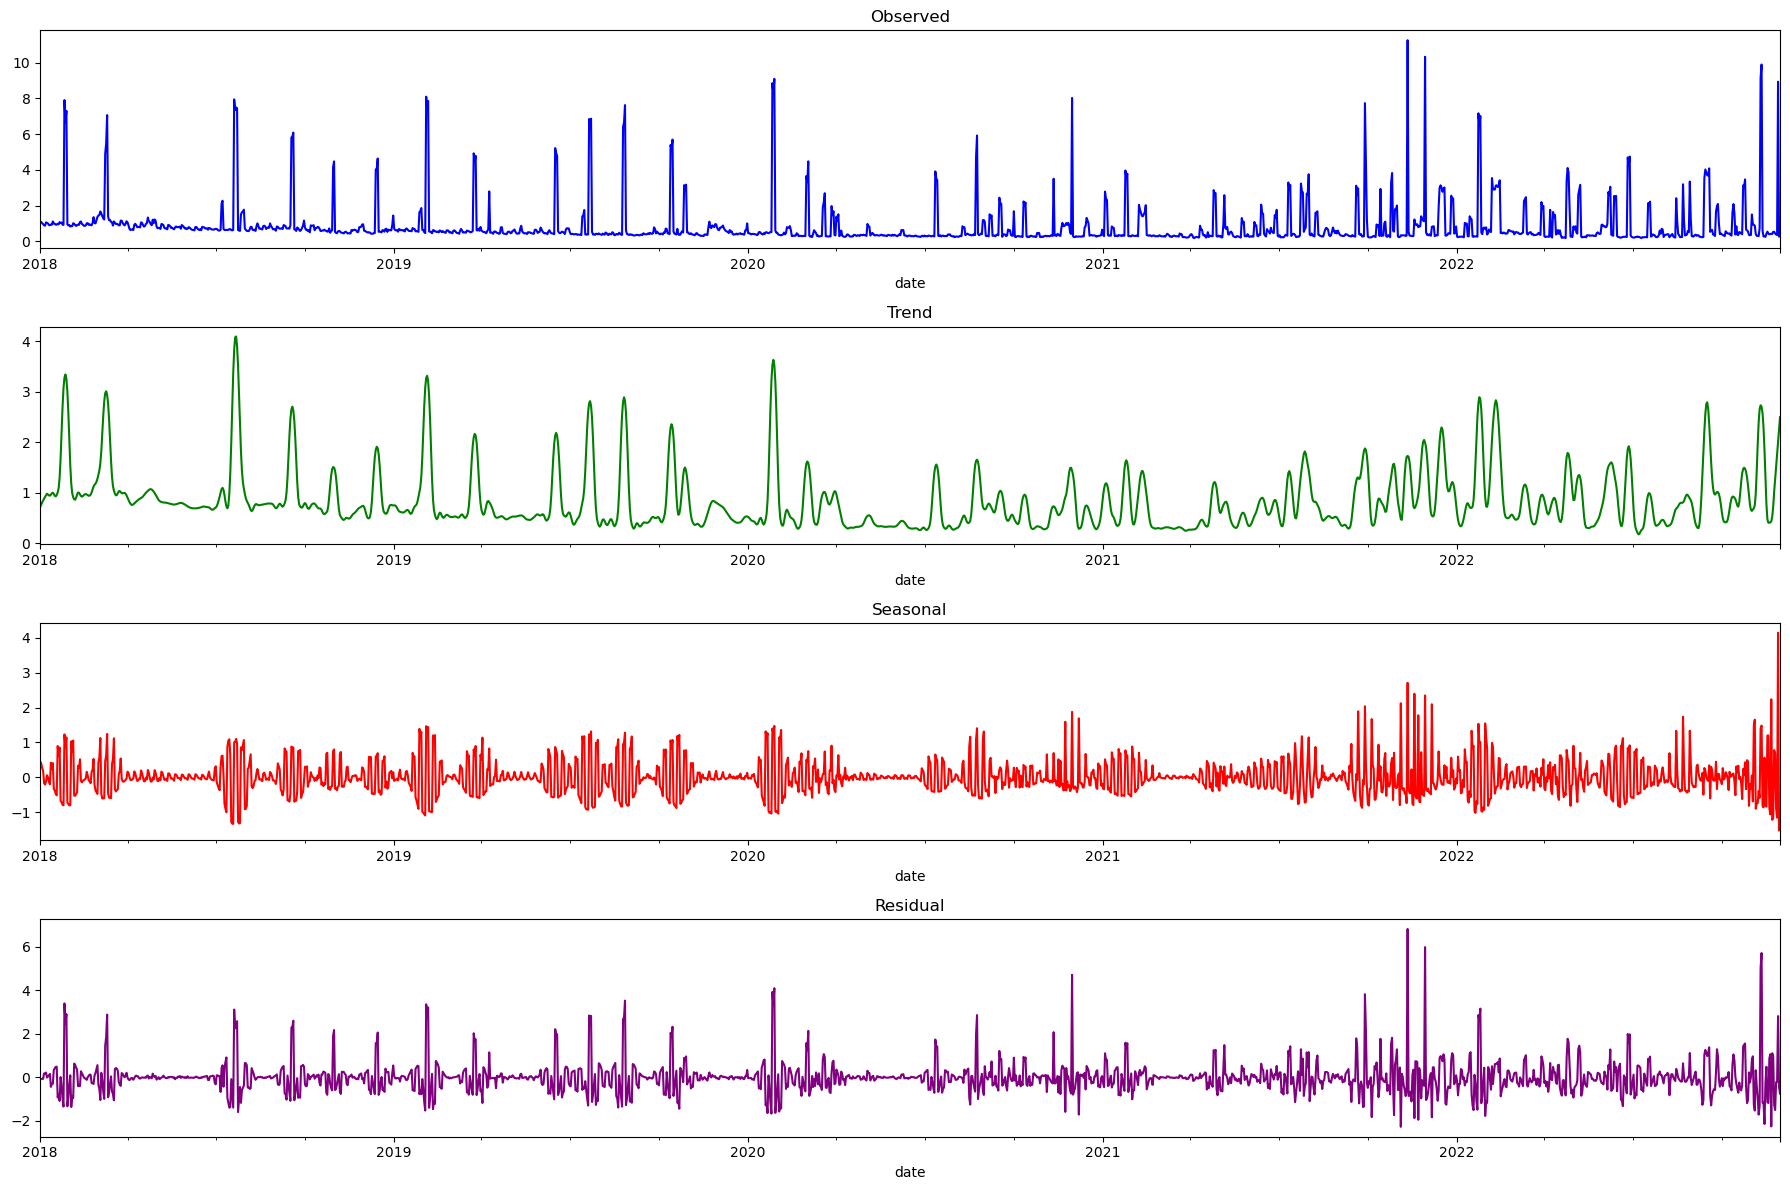

In [35]:
plot_seasonal(df, column_name='coupon_rate', period=7, figsize=(18, 12))

# Modelling and Evaluations

In [36]:
from statsmodels.tsa.stattools import adfuller, kpss

In [37]:
# Perform Augmented Dickey-Fuller and Kwiatkowski–Phillips–Schmidt–Shin Test
# 'result' contains the test statistic and the p-value.

def check_stationarity(df, column_name='revenue', alpha=.05, diff = 0, return_plot=False, return_stat = False):
    df = df.copy()

    if diff != 0:
        df = df.diff(diff)
        df = df.dropna()
    
    adf_res = adfuller(df[column_name])
    kpss_res = kpss(df[column_name])
    
   
    # Interpreting the results
    if (adf_res[1] < alpha) & (kpss_res[1] > alpha):
        print("====================== Time Series is STATIONARY =====================\n")
    else:
        print("====================== NOT STATIONARY =============================\n")

    print(f"For stationary, p-value ADF < {alpha} and p-value KPSS > {alpha}")
    print(f"The Results:")
    print(f'p-value ADF : {adf_res[1] :.4f} | Significane : {adf_res[0] :.4f}')
    print(f'p-value KPSS: {kpss_res[1] :.4f} | Significane : {kpss_res[0] :.4f}')
    print("=================================================================\n")

    if return_plot:
        fig, ax = plt.subplots(1,1,figsize=(12,6))
        
        df[column_name].plot(ax=ax)
        
        column_name = column_name.replace("_", " ").title()
        plt.suptitle(f"{column_name} Plot with Diff={diff}", size=16)
        plt.show();

    if return_stat:
        return adf_res[1], kpss_res[1]

## Finding The Estimate of Non-Seasonal and Seasonal Difference order

### Non Seasonal Order (d)

In [38]:
# for d = 0
d=0
check_stationarity(df, column_name='revenue', diff=d)

====================== NOT STATIONARY =============================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.1019 | Significane : -2.5584
p-value KPSS: 0.0100 | Significane : 5.0422



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(df[column_name])


In [39]:
# for d = 0
d=1
check_stationarity(df, column_name='revenue', diff=d)

====================== Time Series is STATIONARY =====================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.0000 | Significane : -12.8088
p-value KPSS: 0.1000 | Significane : 0.0268



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


In [40]:
# for d = 2
d=2
check_stationarity(df, column_name='revenue', diff=d)

====================== Time Series is STATIONARY =====================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.0000 | Significane : -11.1902
p-value KPSS: 0.1000 | Significane : 0.0686



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


d = 1 is suffecient to make non-seasonal pattern become stationer

In [41]:
df['revenue_diff1'] = df['revenue'].diff(1)
df['revenue_diff2'] = df['revenue'].diff(2)

### Seasonal Order (D)

In [42]:
# for m = 365
m = 7
# for D = 1
D = 1

check_stationarity(df, column_name='revenue_diff1', diff=m*D)

====================== Time Series is STATIONARY =====================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.0000 | Significane : -15.2241
p-value KPSS: 0.1000 | Significane : 0.0202



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


In [43]:
# for D = 1
D = 1

check_stationarity(df, column_name='revenue_diff2', diff=m*D)

====================== Time Series is STATIONARY =====================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.0000 | Significane : -15.4491
p-value KPSS: 0.1000 | Significane : 0.0075



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


In [44]:
# for D = 2
D = 2

check_stationarity(df, column_name='revenue_diff1', diff=m*D)

====================== Time Series is STATIONARY =====================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.0000 | Significane : -16.5449
p-value KPSS: 0.1000 | Significane : 0.0133



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


In [45]:
# for D = 2
D = 2

check_stationarity(df, column_name='revenue_diff2', diff=m*D)

====================== Time Series is STATIONARY =====================

For stationary, p-value ADF < 0.05 and p-value KPSS > 0.05
The Results:
p-value ADF : 0.0000 | Significane : -9.6162
p-value KPSS: 0.1000 | Significane : 0.0151



C:\Users\HP\AppData\Local\Temp\ipykernel_8736\2520388838.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(df[column_name])


applying D = 1 on d=1 could make the data more stationary rather than d=1 alone. and also, D=1 and d=0 cannot make the data stationary.

so for simplicity, we will use d=1, and D=1 to make data stationary.

### See Data After Differencing

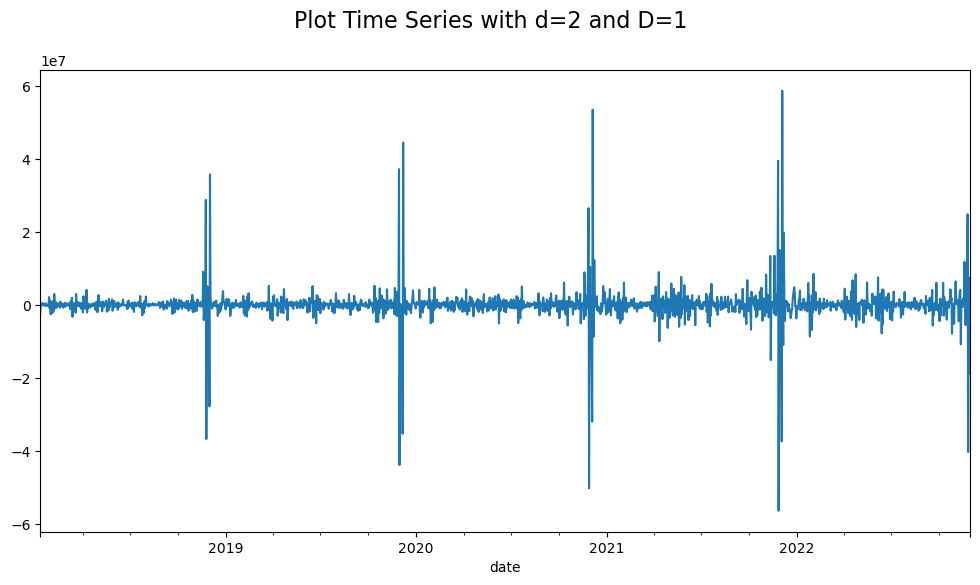

In [47]:
D=1

df['diff'] = df['revenue_diff1'].diff(m*D)

fig, ax = plt.subplots(1,1,figsize=(12,6))

df['diff'].dropna().plot(ax=ax)

plt.suptitle(f"Plot Time Series with d={d} and D={D}", size=16)
plt.show();

### Analyze Possible p, q, P and Q Order

In [48]:
def plot_autocorrelations(df, column_name='diff', lags=50):   
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    
    plot_acf(df[column_name].dropna(), lags=lags, ax=ax1)
    plot_pacf(df[column_name].dropna(), lags=lags, ax=ax2)
    
    plt.suptitle(f"ACF dan PACF Plots for {column_name.title()} Weekly Data, [Lags={lags}]", size=16)
    plt.tight_layout()
    plt.show();

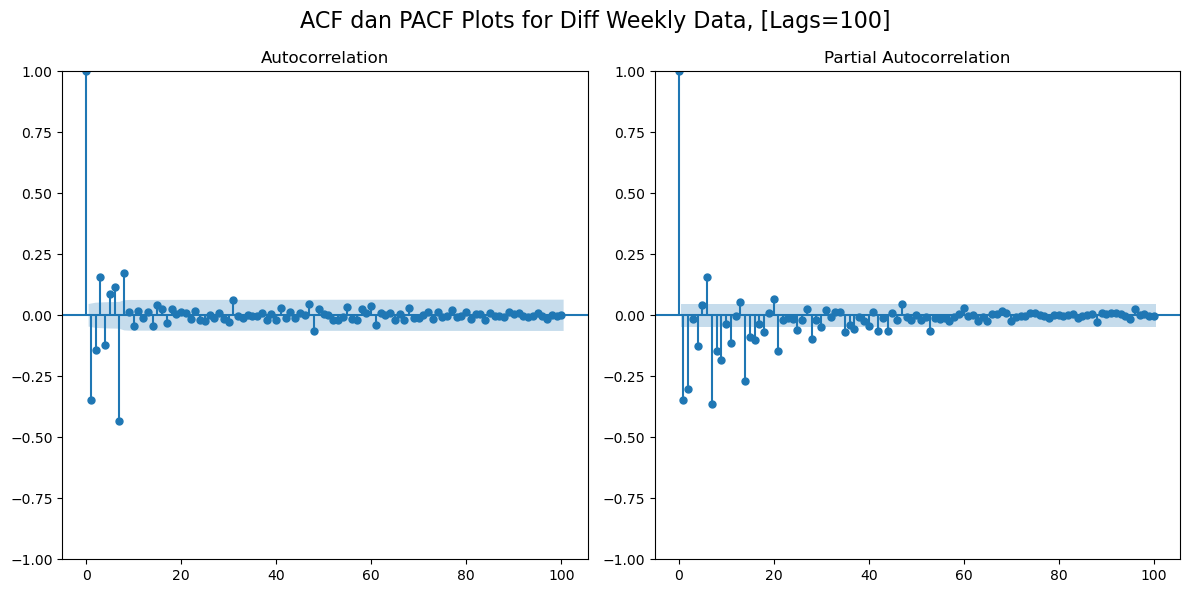

In [49]:
plot_autocorrelations(df, lags=100)

## Tuning Hyperparameters

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
from pmdarima import ARIMA, model_selection
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_percentage_error
)

In [53]:
# Defining the parameters
param_grid = {'p': [2,3],
              'd': [1],
              'q': [2],
              'P': [3,5],
              'D': [1],
              'Q': [0,1]}
grid = ParameterGrid(param_grid)
list(grid)

[{'D': 1, 'P': 3, 'Q': 0, 'd': 1, 'p': 2, 'q': 2},
 {'D': 1, 'P': 3, 'Q': 0, 'd': 1, 'p': 3, 'q': 2},
 {'D': 1, 'P': 3, 'Q': 1, 'd': 1, 'p': 2, 'q': 2},
 {'D': 1, 'P': 3, 'Q': 1, 'd': 1, 'p': 3, 'q': 2},
 {'D': 1, 'P': 5, 'Q': 0, 'd': 1, 'p': 2, 'q': 2},
 {'D': 1, 'P': 5, 'Q': 0, 'd': 1, 'p': 3, 'q': 2},
 {'D': 1, 'P': 5, 'Q': 1, 'd': 1, 'p': 2, 'q': 2},
 {'D': 1, 'P': 5, 'Q': 1, 'd': 1, 'p': 3, 'q': 2}]

In [54]:
# Initialize an empty list to store RMSE values for each parameter set
mse_list = []
test_size = 365
step_roll = 90
horizon = 7

# Iterate over each set of parameters in the grid
calc = 1
for params in grid:
    if calc=1:
        print("Calculation Started")
    
    print(f"Calculation {calc} from {len(grid)}")
    # Build an ARIMA model with the current set of parameters
    model = ARIMA(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'], 7))
    
    # Define the Rolling Forecast Cross-Validation strategy
    cv = model_selection.RollingForecastCV(h=horizon,
                                         step=step_roll,
                                         initial=df.shape[0] - test_size)
    
    # Perform cross-validation scoring with the ARIMA model
    cv_score = model_selection.cross_val_score(model,
                                             y=df['revenue'],  # Target variable 'y'
                                             #X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=np.inf  # Value to assign if fitting error occurs
                                             )
    
    # Calculate RMSE and store the error
    mse_list.append(cv_score)
    calc+=1

print("Calculation Done")

Calculation 1 from 8
Calculation 2 from 8
Calculation 3 from 8
Calculation 4 from 8
Calculation 5 from 8
Calculation 6 from 8
Calculation 7 from 8
Calculation 8 from 8


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


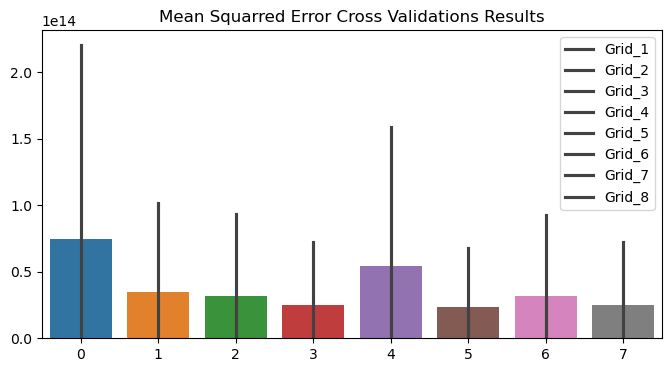

In [83]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot(mse_list)
plt.legend(["Grid_"+str(i) for i in range(1,len(grid)+1)])
plt.title("Mean Squarred Error Cross Validations Results")
plt.show();

In [57]:
# Create a DataFrame to store the tuning results with parameters and corresponding RMSE values
tuning_results = pd.DataFrame(grid)

# Add the RMSE values calculated during parameter tuning to the DataFrame
tuning_results['mse'] = np.mean(mse_list, axis=1)

tuning_results

,D,P,Q,d,p,q,mse
0,1,3,0,1,2,2,7.453677e+13
1,1,3,0,1,3,2,3.507278e+13
2,1,3,1,1,2,2,3.182697e+13
3,1,3,1,1,3,2,2.497162e+13
4,1,5,0,1,2,2,5.437007e+13
5,1,5,0,1,3,2,2.383612e+13
6,1,5,1,1,2,2,3.196159e+13
7,1,5,1,1,3,2,2.490982e+13


In [58]:
# Save the best parameters
best_params = tuning_results[tuning_results['mse'] == tuning_results['mse'].min()].transpose()
best_params

,5
D,1.000000e+00
P,5.000000e+00
Q,0.000000e+00
d,1.000000e+00
p,3.000000e+00
q,2.000000e+00
mse,2.383612e+13


In [63]:
best_params.columns.item()

5

# Future Forecast

In [59]:
# target variable - daily revenue
y = df['revenue']
# exogenous variables
# X = df.iloc[:,1:3]

In [64]:
# Fetch the best parameters
p = int(best_params.loc['p', best_params.columns.item()])
d = int(best_params.loc['d', best_params.columns.item()])
q = int(best_params.loc['q', best_params.columns.item()])
P = int(best_params.loc['P', best_params.columns.item()])
D = int(best_params.loc['D', best_params.columns.item()])
Q = int(best_params.loc['Q', best_params.columns.item()])

In [67]:
# Tuned Sarimax Model with the best parameters
tuned_model = ARIMA(order = (p, d, q),
                    seasonal_order = (P, D, Q, 7))
# fit the model, add exogenous variables as X
tuned_model.fit(y)

ARIMA(order=(3, 1, 2), seasonal_order=(5, 1, 0, 7))

In [68]:
tuned_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1795
Model:             SARIMAX(3, 1, 2)x(5, 1, [], 7)   Log Likelihood              -29421.773
Date:                            Wed, 09 Oct 2024   AIC                          58867.547
Time:                                    21:45:58   BIC                          58933.406
Sample:                                01-01-2018   HQIC                         58891.867
                                     - 11-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8036.7848   1.01e+04     -0.796      0.426   -2.78e+04    1.18e+04
ar.L1          0.0002      0.118      0.001      0.999      -0.231       0.231
ar.L2          0.2212      0.053      4.191      0.000       0.118       0.325
ar.L3          0.2144      0.028      7.655      0.000       0.160       0.269
ma.L1         -0.5459      0.119     -4.600      0.000      -0.779      -0.313
ma.L2         -0.4118      0.107     -3.855      0.000      -0.621      -0.202
ar.S.L7       -0.7303      0.019    -38.863      0.000      -0.767      -0.693
ar.S.L14      -0.5549      0.024    -23.144      0.000      -0.602      -0.508
ar.S.L21      -0.3985      0.029    -13.794      0.000      -0.455      -0.342
ar.S.L28      -0.2835      0.030     -9.353      0.000      -0.343      -0.224
ar.S.L35      -0.1550      0.028     -5.536      0.000      -0.210      -0.100
sigma2      1.746e+13      0.000   1.18e+17      0.000    1.75e+13    1.75e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            510593.90
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             4.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        85.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+31. Standard errors may be unstable.
"""

In [70]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

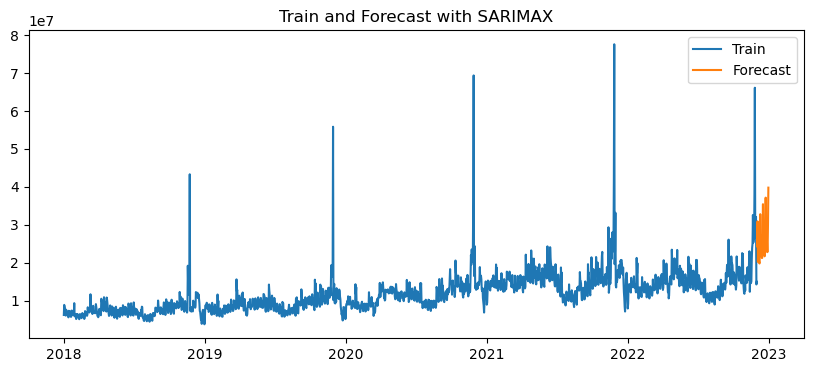

In [81]:
# Forecasting
# set the number of periods to forecast to the length of 'X_future'
# add future exogenous variables as X
predictions = tuned_model.predict(n_periods = 30)

# Data Visualization
plot_future(df.loc[:, 'revenue'], predictions, "SARIMAX")

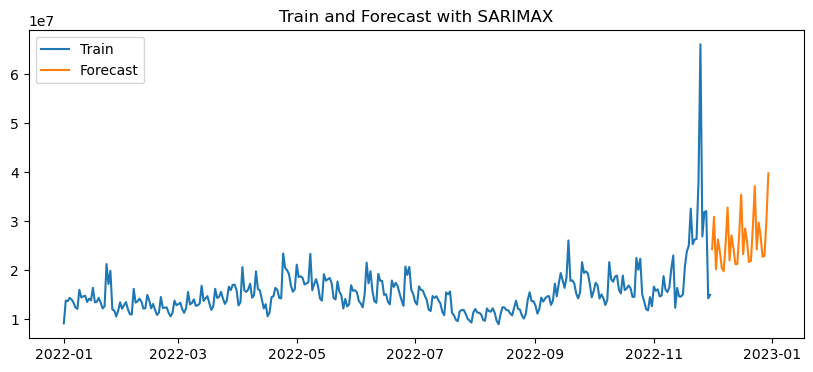

In [82]:
# Data Visualization
plot_future(df.loc['2022', 'revenue'], predictions, "SARIMAX")

# Evaluation:

    The model doesnt learn well on data, since we have only can capture Yt-7 day before (D=1, and m=7, capture: m*D). so basically the model just learn from 7 days before and captures only weekly trend. if the trend was increasing in the last week, than the predicted trend must be increasing to. And from statistical analysis in exploratory data analysis indicates that yearly seasonality is the strongest over weekly, monthly, and quarterly data that we need to include yearly seasonality. BUt introducing yearly seasonality needs huge computational resources and it is better to be done with other model such as FBProhet, LinkedinSilverkite, LSTM, or other relevant model. But it is also worth to try to aggregate data into monthly frequancies so it could capture yearly seasonality without putting a tremendous effort on computational process.